# Import some helpful libs

In [56]:
import os
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import math
np.random.seed(0)

rng = np.random.RandomState(42)

def im2mat(img):
    """Converts an image to matrix (one pixel per line)"""
    return img.reshape((img.shape[0] * img.shape[1], img.shape[2]))

def mat2im(X, shape):
    """Converts back a matrix to an image"""
    return X.reshape(shape)

def minmax(img):
    return np.clip(img, 0, 1)

# Wasserstein-Entropy closure

In [57]:
def H(x, i):
    return x**i
def dH(x,i):
    if i<1:
        return np.zeros_like(x)
    else:
        return i*x**(i-1)
def d2H(x,i):
    if i<2:
        return np.zeros_like(x)
    else:
        return i*(i-1)*x**(i-2)

def dXY(x,y,m):
    return np.sum(abs(x-y)**m, axis=0)

def Hess_(x,Nm):
    return np.array([[H(x,i)*H(x,j) for i in range(1, Nm+1)] for j in range(1, Nm+1)])
def L_(x,Nm):
    dh =  np.zeros((x.shape[1], Nm, Nm))
    for i in range(Nm):
        for j in range(Nm):
           dh[:, i, j] = dH(x[0, :], id0[i]) * H(x[1, :], id1[i])  * H(x[2, :], id2[i]) \
                         *dH(x[0, :], id0[j]) * H(x[1, :], id1[j]) * H(x[2, :], id2[j])
           dh[:, i, j] += H(x[0, :], id0[i])  * dH(x[1, :], id1[i]) * H(x[2, :], id2[i])\
                          *H(x[0, :], id0[j])  * dH(x[1, :], id1[j]) * H(x[2, :], id2[j])
           dh[:, i, j] += H(x[0, :], id0[i]) * H(x[1, :], id1[i]) * dH(x[2, :], id2[i]) \
                          *H(x[0, :], id0[j]) * H(x[1, :], id1[j]) * dH(x[2, :], id2[j])
    return np.average(dh, axis=0)
def pdhXY_(x, y, Nm, p):
    dh = np.zeros((x.shape[1], Nm))
    dxy = dXY(x, y, p-2)
    for i in range(Nm):
            dh[:, i] = dH(x[0, :], id0[i]) * H(x[1, :], id1[i]) * H(x[2, :], id2[i]) \
                          * p*(x[0,:]-y[0,:])*dxy #abs(x[0,:]-y[0,:])**(p-2)
            dh[:, i] += H(x[0, :], id0[i]) * dH(x[1, :], id1[i]) * H(x[2, :], id2[i]) \
                          * p*(x[1,:]-y[1,:])*dxy #abs(x[1,:]-y[1,:])**(p-2)
            dh[:, i] += H(x[0, :], id0[i]) * H(x[1, :], id1[i]) * dH(x[2, :], id2[i]) \
                        * p * (x[2, :] - y[2, :])*dxy ## * abs(x[2, :] - y[2, :]) ** (p - 2)
    return np.average(dh, axis=0)


def moms(x,Nm):
  mom = np.zeros(Nm)
  for i in range(Nm):
      mom[i] = np.average(H(x[0,:], id0[i]) * H(x[1,:], id1[i]) * H(x[2,:], id2[i]))
  return mom
def dH_(x, Nm):
    dh = np.zeros((3,x.shape[1], Nm))
    for i in range(Nm):
        dh[0, :, i] = dH(x[0, :], id0[i]) * H(x[1, :], id1[i])  * H(x[2, :], id2[i])
        dh[1, :, i] =  H(x[0, :], id0[i]) * dH(x[1, :], id1[i]) * H(x[2, :], id2[i])
        dh[2, :, i] =  H(x[0, :], id0[i]) * H(x[1, :], id1[i])  * dH(x[2, :], id2[i])
    return dh
def dmoms(x,Nm):
  mom = np.zeros((3,Nm))
  for i in range(Nm):
      mom[0, i] = np.average(dH(x[0, :], id0[i]) * H(x[1, :], id1[i])  * H(x[2, :], id2[i]))
      mom[1, i] = np.average(H(x[0, :], id0[i])  * dH(x[1, :], id1[i]) * H(x[2, :], id2[i]))
      mom[2, i] = np.average(H(x[0, :], id0[i])  * H(x[1, :], id1[i])  * dH(x[2, :], id2[i]))
  return mom
def d2moms(x,Nm):
  Np = x.shape[1]
  mom = np.zeros((Np, Nm))
  for i in range(Nm):
      mom[:, i] =  d2H(x[0, :], id0[i]) * H(x[1, :], id1[i])   * H(x[2, :], id2[i])
      mom[:, i] += H(x[0, :], id0[i])   * d2H(x[1, :], id1[i]) * H(x[2, :], id2[i])
      mom[:, i] += H(x[0, :], id0[i])   * H(x[1, :], id1[i])   * d2H(x[2, :], id2[i])
  return np.average(mom, axis=0)

def WE_3D(Xs, Xt, id0, id1, id2, Nt=100, dt=1.e-9, dt0=1e-12, beta=1e-2):
  Nm = len(id0)
  p = 2 #math.ceil( (np.max(id0)+1) / 2.)*2

  X = Xs.T.copy()
  X0 = X.copy()
  Y = Xt.T.copy()
  Y0 = Y.copy()
  PXt = moms(Xt.T, Nm)
  PYt = moms(Xs.T, Nm)

  lx = np.zeros(Nm)
  wdist = [ np.average(np.linalg.norm(X-Y,axis=0) ) ]
  dtX = dt0
  dtY = dt0
  for i in range(Nt):
    tau = 10*dtX

    d2h = d2moms(X,Nm)
    P = moms(X, Nm)
    #const = 0.01/Nm*dt/tau*np.linalg.norm(P - PXt, ord=2) ** 2 / np.linalg.norm(P, ord=2) ** 2

    L = L_(X,Nm)
    pdhXY = pdhXY_(X, Y, Nm, p)
    #b = (PXt-P)/tau*(1.-const) - d2h + pdhXY*const
    b = (PXt-P)/tau - d2h + pdhXY/beta
    lx = np.linalg.solve(L, b)
    dxy = dXY(X, Y, p-2)
    A = np.sum(lx* dH_(X,Nm), axis=2) - p*(X-Y)*dxy/beta
    dW = np.random.normal(0., 1., X.shape)

    #m = np.mean(Y0); v = np.var(Y0)
    X = X + A*dtX + (2.*dtX)**0.5*dW
    dtX = min(dt, 0.01/np.max(abs(A)) )

    tau = 10*dtY
    d2h = d2moms(Y,Nm)
    L = L_(Y,Nm)
    P = moms(Y, Nm)
    #const = 0.01/Nm*dt/tau*np.linalg.norm(P - PYt, ord=2) ** 2 / np.linalg.norm(P, ord=2) ** 2
    pdhXY = pdhXY_(Y, X, Nm, p)
    #b = (PYt-P)/tau*(1.-const) - d2h + pdhXY*const
    b = (PYt-P)/tau - d2h + pdhXY/beta
    lx = np.linalg.solve(L, b)
    dxy = dXY(X, Y, p-2)
    A = np.sum(lx* dH_(Y,Nm), axis=2) - p*(Y-X)*dxy/beta
    dW = np.random.normal(0., 1., X.shape)

    #m = np.mean(X0); v = np.var(X0)
    Y = Y + A*dtY + (2.*dtY)**0.5*dW
    dtY = min(dt, 0.01/np.max(abs(A)) )

    dist = np.average(np.linalg.norm(X-Y,axis=0) )
    wdist.append( dist )
  return X, Y, wdist


# For comparison with EMD/Sinkhorn

In [58]:
! pip3 install POT
import ot

# Example: daylight to sunset

shape of first image: (75, 75, 3)
shape of second image: (75, 75, 3)


Text(0.5, 1.0, 'Image 2')

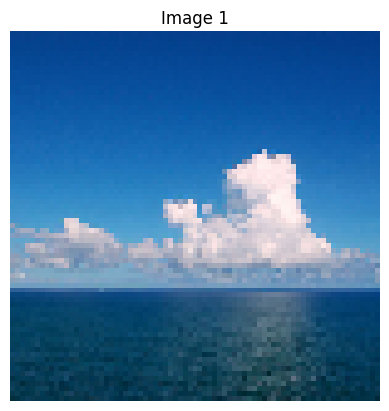

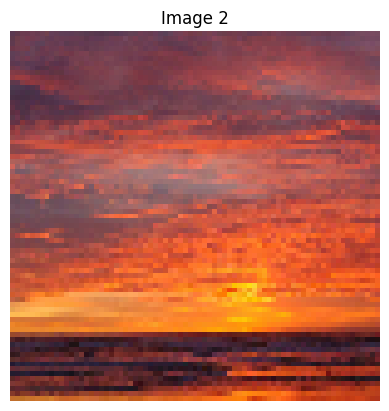

In [66]:
I1 = plt.imread('ocean_day.jpg').astype(np.float64)/256
I2 = plt.imread('ocean_sunset.jpg').astype(np.float64)/256

## look at lower resolution picture
## make sure images have the same dimension at the end
I1c = I1[:600,100:700][::8,::8]#[::13,::15,::]
X1c = im2mat(I1c)

I2c = I2[:600,100:700][::8,::8]#[::13,::15,::]
X2c = im2mat(I2c)

Xs = X1c
Xt = X2c
Xs.shape

day = im2mat(I1c)
sunset = im2mat(I2c)

print("shape of first image:", I1c.shape)
print("shape of second image:", I2c.shape)
plt.figure()
plt.imshow(I1c)
plt.axis('off')
plt.title('Image 1')

plt.figure()
plt.imshow(I2c)
plt.axis('off')
plt.title('Image 2')


## Find the optimal map using WE for a range of matching moments

In [60]:
id0s = [[1,0,0, 2,0,0,1,1,0] # WE(2)
        ,[1,0,0, 2,0,0,1,1,0, 3,0,0,2,2,1,0,1,0] # WE(3)
       # ,[1,0,0, 2,0,0,1,1,0, 3,0,0,2,2,1,0,1,0, 4,0,0,3,3,1,0,1,0] # WE(4)
       # ,[0,0,1, 0,0,2,0,1,1, 0,0,3,0,1,0,1,2,2, 0,0,4,0,1,0,1,3,3, 2,0,2] # WE(5)
        ]
id1s = [[0,1,0, 0,2,0,1,0,1]
        ,[0,1,0, 0,2,0,1,0,1, 0,3,0,1,0,2,2,0,1]
       # ,[0,1,0, 0,2,0,1,0,1, 0,3,0,1,0,2,2,0,1, 0,4,0,1,0,3,3,0,1]
       # ,[0,0,1, 0,0,2,0,1,1, 0,0,3,0,1,0,1,2,2, 0,0,4,0,1,0,1,3,3, 2,2,0]
        ]
id2s = [[0,0,1, 0,0,2,0,1,1]
        ,[0,0,1, 0,0,2,0,1,1, 0,0,3,0,1,0,1,2,2]
       # ,[0,0,1, 0,0,2,0,1,1, 0,0,3,0,1,0,1,2,2, 0,0,4,0,1,0,1,3,3]
       # ,[0,0,1, 0,0,2,0,1,1, 0,0,3,0,1,0,1,2,2, 0,0,4,0,1,0,1,3,3, 0,2,2]
        ]

Xsn = Xs.copy()
Xtn = Xt.copy()
WE_X = []
WE_Y = []
for nids in range(len(id0s)):
  id0 = id0s[nids]
  id1 = id1s[nids]
  id2 = id2s[nids]
  X, Y, wdist = WE_3D(Xsn, Xtn, id0, id1, id2, Nt=50, dt=1.e-6)
  WE_X.append(X)
  WE_Y.append(Y)
  print("nids=", nids+1)

nids= 1
nids= 2


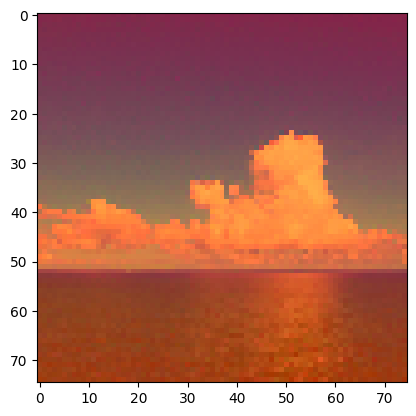

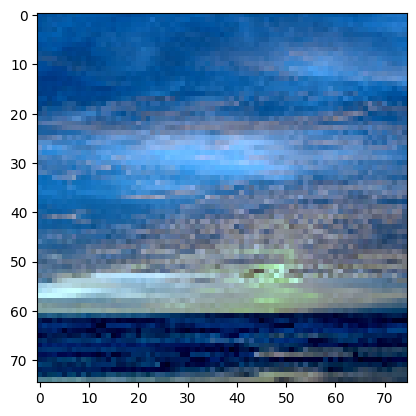

In [61]:
I1_WE = minmax(mat2im(WE_X[0].T, I1c.shape))
I2_WE = minmax(mat2im(WE_Y[0].T, I2c.shape))

plt.figure()
plt.imshow(I1_WE)

plt.figure()
plt.imshow(I2_WE)


# Find OT using EMD and Sinkhorn

In [62]:
# EMDTransport
ot_emd = ot.da.EMDTransport()
ot_emd.fit(Xs=Xs.copy(), Xt=Xt.copy())

# SinkhornTransport
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
ot_sinkhorn.fit(Xs=Xs.copy(), Xt=Xt.copy())

# prediction between images (using out of sample prediction as in [6])
transp_Xs_emd = ot_emd.transform(Xs=X1c)
transp_Xt_emd = ot_emd.inverse_transform(Xt=X2c)

transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=X1c)
transp_Xt_sinkhorn = ot_sinkhorn.inverse_transform(Xt=X2c)

I1t = minmax(mat2im(transp_Xs_emd, I1c.shape))
I2t = minmax(mat2im(transp_Xt_emd, I2c.shape))

I1te = minmax(mat2im(transp_Xs_sinkhorn, I1c.shape))
I2te = minmax(mat2im(transp_Xt_sinkhorn, I2c.shape))

/home/sadr/miniconda3/lib/python3.9/site-packages/ot/lp/__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


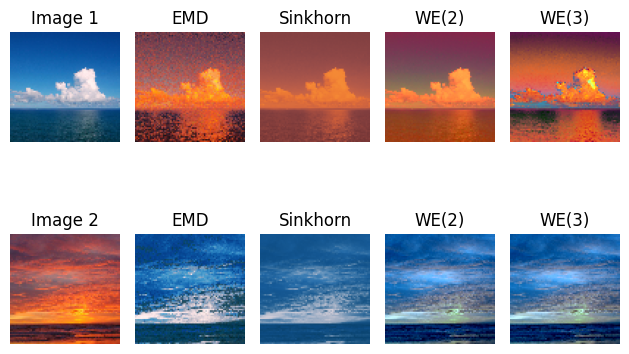

In [65]:
plt.plot(wdist)

plt.subplot(2, 5, 1)
plt.imshow(I1c)
plt.axis('off')
plt.title('Image 1')

plt.subplot(2, 5, 2)
plt.imshow(I1t)
plt.axis('off')
plt.title('EMD')

plt.subplot(2, 5, 3)
plt.imshow(I1te)
plt.axis('off')
plt.title('Sinkhorn')

I1_WE = minmax(mat2im(WE_X[0].T, I1c.shape))

plt.subplot(2, 5, 4)
plt.imshow(I1_WE)
plt.axis('off')
plt.title('WE(2)')

I1_WE = minmax(mat2im(WE_X[1].T, I1c.shape))

plt.subplot(2, 5, 5)
plt.imshow(I1_WE)
plt.axis('off')
plt.title('WE(3)')


plt.subplot(2, 5, 6)
plt.imshow(I2c)
plt.axis('off')
plt.title('Image 2')

plt.subplot(2, 5, 7)
plt.imshow(I2t)
plt.title('EMD')
plt.axis('off')

plt.subplot(2, 5, 8)
plt.imshow(I2te)
plt.axis('off')
plt.title('Sinkhorn')

I1_WE = minmax(mat2im(WE_Y[0].T, I1c.shape))

plt.subplot(2, 5, 9)
plt.imshow(I2_WE)
plt.axis('off')
plt.title('WE(2)')

I1_WE = minmax(mat2im(WE_Y[1].T, I1c.shape))

plt.subplot(2, 5, 10)
plt.imshow(I2_WE)
plt.axis('off')
plt.title('WE(3)')

plt.tight_layout()
#plt.savefig("comparison_ocean.pdf",format='pdf', bbox_inches="tight", dpi=300);
plt.show()

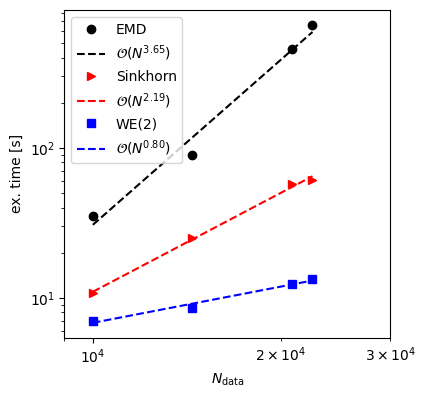

In [64]:
from scipy.stats import linregress

def fit_xp(x, y):
    log_x = np.log10(x)
    log_y = np.log10(y)

    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
    slope_str = f'{slope:.2f}'

    fitted_y = 10**(intercept + slope * log_x)
    return slope, slope_str, fitted_y

## Here, we write the execution time for EMD, Sinkhorn, WE for a range of picture sizes
times_EMD = [35.3, 90, 454.04, 663.7]
times_sinkhorn = [10.7, 25.2, 57.6, 61]
times_WE2 = [7.02, 8.57, 12.4, 13.25]
grid_size = [100*100, 120*120, 125*167, 150*150]


emd_slope, emd_slope_str, emd_fitted_y = fit_xp(grid_size, times_EMD)
sinkhorn_slope, sinkhorn_slope_str, sinkhorn_fitted_y = fit_xp(grid_size, times_sinkhorn)
WE2_slope, WE2_slope_str, WE2_fitted_y = fit_xp(grid_size, times_WE2)

xx = np.linspace(0.9*np.min(grid_size), np.max(grid_size)*(1.1), 100)

fig = plt.figure()
size = 10;
cm = 0.393701; #inches

plt.plot(grid_size, times_EMD, label="EMD", marker="o", color="black", linewidth=0)
plt.plot(grid_size, emd_fitted_y, color="black", linestyle="--", label=r"$\mathcal{O}(N^{"+emd_slope_str+"})$")

plt.plot(grid_size, times_sinkhorn, label="Sinkhorn", marker=">", color="red", linewidth=0)
plt.plot(grid_size, sinkhorn_fitted_y, color="red", linestyle="--", label=r"$\mathcal{O}(N^{"+sinkhorn_slope_str+"})$")

plt.plot(grid_size, times_WE2, label="WE(2)", marker="s", color="blue", linewidth=0)
plt.plot(grid_size, WE2_fitted_y, color="blue", linestyle="--", label=r"$\mathcal{O}(N^{"+WE2_slope_str+"})$")
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"$N_\mathrm{data}$")
plt.ylabel(r"ex. time [s]")
plt.legend()

plt.xticks([1000,10000],[r'$10^3$',r'$10^4$'])
plt.xlim([9000,30000])

plt.tight_layout()

name = "timing"
fig.set_size_inches(size*cm, size*cm)
#plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300);

params[1]*np.array(grid_size)**params[0]